# VGG16 Convolutional Neural Network for Lingzhi Mushroom Images

Implementation of the VGG-16 architecture for training a Growth Measurement Methodology for Lingzhi Mushroom classifier.

## Imports

In [1]:
import time
import os

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
%matplotlib inline

## Settings

In [3]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
# NUM_EPOCHS = 100
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Architecture
NUM_CLASSES = 2

## Lingzhi Mushrooms Dataset

In [4]:
import os

num_train_mycelium = len([i for i in os.listdir(os.path.join('datasets-composite_method', 'train_vgg')) 
                      if i.endswith('.jpg') and i.startswith('mycelium_grown')])

num_train_fruiting_body = len([i for i in os.listdir(os.path.join('datasets-composite_method', 'train_vgg')) 
                      if i.endswith('.jpg') and i.startswith('fruiting_body_grown-spore_massively_produced')])

print(f'Training set mycelium: {num_train_mycelium}')
print(f'Training set fruiting body: {num_train_fruiting_body}')

Training set mycelium: 133
Training set fruiting body: 153


(1944, 2592, 3)


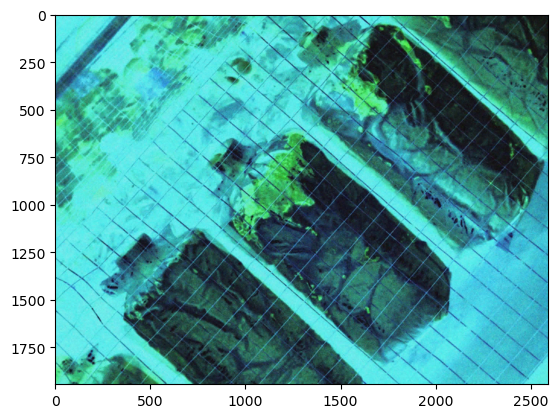

In [5]:
img = Image.open(os.path.join('datasets-composite_method','train_vgg', 'fruiting_body_grown-spore_massively_produced.CMFG0101_20220129T1000.jpg.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Creating Validation and Test Subsets

In [6]:
# if not os.path.exists(os.path.join('datasets-composite_method', 'test_vgg')):
#     os.mkdir(os.path.join('datasets', 'test_vgg'))

# if not os.path.exists(os.path.join('datasets-composite_method', 'valid_vgg')):
#     os.mkdir(os.path.join('datasets', 'valid_vgg'))

### Standardizing Images

Getting mean and standard devation for normalizing images via z-score normalization.

In [7]:
class MyceliumsFruitingbodysDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'mycelium_grown':
                self.y.append(0)
            else:
                self.y.append(1)
        
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

    

custom_transform1 = transforms.Compose([transforms.Resize([64, 64]),
                                        transforms.ToTensor()])

train_dataset = MyceliumsFruitingbodysDataset(img_dir=os.path.join('datasets-composite_method', 'train_vgg'), 
                                transform=custom_transform1)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=5000, 
                          shuffle=False)

train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.2125, 0.6151, 0.5542])
Std Dev: tensor([0.1054, 0.2514, 0.2680])


### Dataloaders

In [8]:
data_transforms = {
    'train_vgg': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid_vgg': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


train_dataset = MyceliumsFruitingbodysDataset(img_dir=os.path.join('datasets-composite_method', 'train_vgg'), 
                                transform=data_transforms['train_vgg'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = MyceliumsFruitingbodysDataset(img_dir=os.path.join('datasets-composite_method', 'valid_vgg'), 
                                transform=data_transforms['valid_vgg'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_dataset = MyceliumsFruitingbodysDataset(img_dir=os.path.join('datasets-composite_method', 'test_vgg'), 
                               transform=data_transforms['valid_vgg'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

## Model

In [9]:
##########################
### MODEL
##########################

class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),   
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
        
        self.classifier = nn.Sequential(
                nn.Linear(512*2*2, 4096),
                nn.ReLU(),   
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, num_classes)
        )
            
        
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                #m.weight.data.normal_(0, np.sqrt(2. / n))
                m.weight.detach().normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                m.weight.detach().normal_(0, 0.05)
                m.bias.detach().detach().zero_()
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(-1, 512*2*2))
        probas = F.softmax(logits, dim=1)

        return logits, probas

In [10]:
torch.manual_seed(RANDOM_SEED)
model = VGG16(num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [11]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/002 | Cost: 1259.3157
Epoch: 001/010 Train Acc.: 45.31% | Validation Acc.: 46.50%
Time elapsed: 2.15 min
Epoch: 002/010 | Batch 000/002 | Cost: 18248.2754
Epoch: 002/010 Train Acc.: 54.30% | Validation Acc.: 53.50%
Time elapsed: 4.27 min
Epoch: 003/010 | Batch 000/002 | Cost: 1096.1313
Epoch: 003/010 Train Acc.: 46.88% | Validation Acc.: 46.50%
Time elapsed: 6.43 min
Epoch: 004/010 | Batch 000/002 | Cost: 665.5126
Epoch: 004/010 Train Acc.: 53.12% | Validation Acc.: 53.50%
Time elapsed: 8.52 min
Epoch: 005/010 | Batch 000/002 | Cost: 98.6266
Epoch: 005/010 Train Acc.: 46.48% | Validation Acc.: 46.50%
Time elapsed: 11.09 min
Epoch: 006/010 | Batch 000/002 | Cost: 197.1542
Epoch: 006/010 Train Acc.: 54.69% | Validation Acc.: 53.50%
Time elapsed: 13.14 min
Epoch: 007/010 | Batch 000/002 | Cost: 229.0564
Epoch: 007/010 Train Acc.: 53.91% | Validation Acc.: 53.50%
Time elapsed: 15.20 min
Epoch: 008/010 | Batch 000/002 | Cost: 10.8315
Epoch: 008/010 Train Acc.: 47.

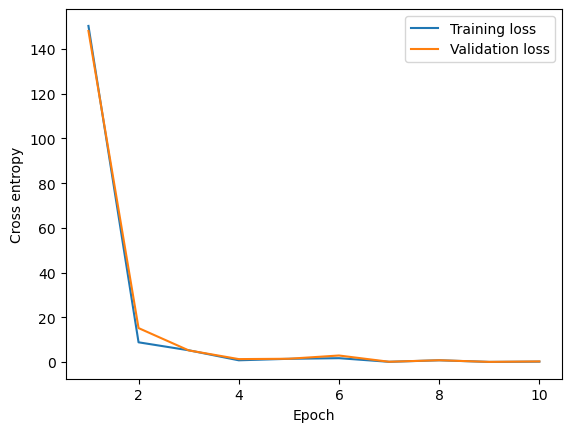

In [12]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

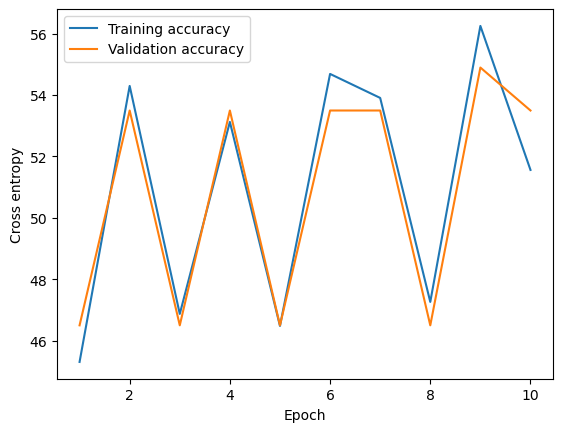

In [13]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

## Evaluation

In [14]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 53.50%


In [15]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
    
unorm = UnNormalize(mean=train_mean, std=train_std)

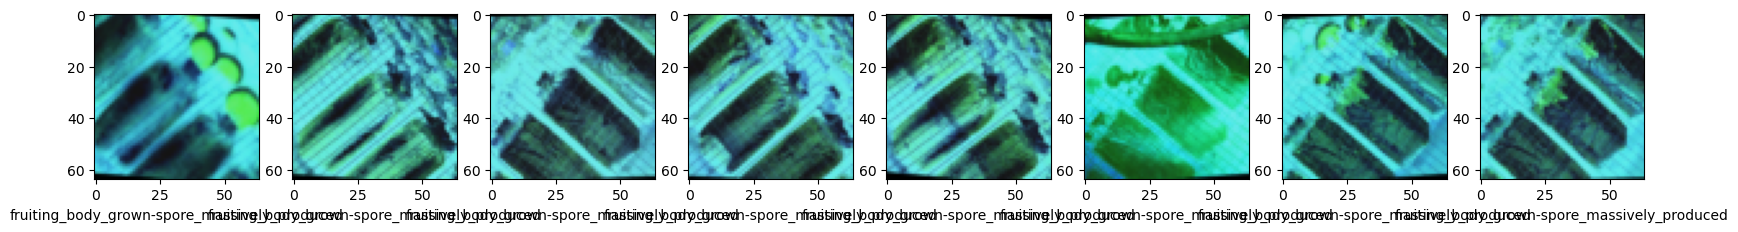

In [16]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'mycelium_grown',
     1: 'fruiting_body_grown-spore_massively_produced'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()

## Save the Model

In [21]:
#save the weights of the model to hdf5 file 
# model.save_weights("vgg_model-Composite_Method.h5")
torch.save(model.state_dict(), 'vgg_model-Composite_Method.pth')
print("Model Saved.")

Model Saved.


In [22]:
# state_dict = torch.load('checkpoint.pth')
# model.load_state_dict(state_dict)